# Marly LangGraph Integration for Generating NotebookLM Podcasts

This notebook demonstrates how to use Marly with LangGraph to generate a NotebookLM podcast from website data. We will be using Elvis's top 10 ML papers of the week (https://nlp.elvissaravia.com/), scraping for name of the paper, summary, link to the paper, and link to the tweet. This data will be then be saved locally so that you can upload it to NotebookLM and generate a podcast. Unfortunately, NotebookLM does not have APIs to complete the e2e workflow. 

Here is a link to the Oct 7 - Oct 13 podcast: (https://notebooklm.google.com/notebook/78007429-9599-4042-a778-69925b2e79a2/audio)

Marly sits at the tooling layer, allowing an agent to scrape the website based on the schema defined below. This functionality sits in the Processor' agent. The data is then saved locally using the 'Save' agent. 

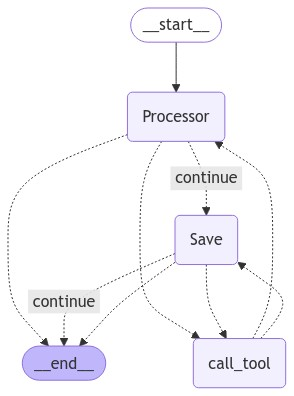

In [50]:
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core marly python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Website URL to scrape
WEBSITE_URL = "https://substack.com/home/post/p-150110065"

# Define schema for Marly, table column name and a brief description of the column
SCHEMA = {
        "Paper Title": "Title of the paper",
        "Summary": "Summary of the paper",
        "Link" : "Link to the paper",
        "Tweet Link" : "Link to the tweet"
    }

# file path to save the data for notebookLM
FILE_PATH = "path/to/save/notebooklm_output.txt"

In [51]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [60]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [61]:
from langchain_core.tools import tool
from marly import Marly
from dotenv import load_dotenv
import time
import json
import os
import logging
import base64
import zlib
import sqlite3
import pandas as pd

load_dotenv()

BASE_URL = "http://localhost:8100"
CLIENT = Marly(base_url=BASE_URL)


def process_website():
    client = Marly(base_url=BASE_URL)

    try:
        pipeline_response = client.pipelines.create(
            api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            provider_model_name=os.getenv("AZURE_MODEL_NAME"),
            provider_type="azure",
            workloads=[{
                "data_source": "web",
                "documents_location": WEBSITE_URL,
                "schemas": [json.dumps(SCHEMA)],
            }
            ],
            additional_params={
                "azure_endpoint": os.getenv("AZURE_ENDPOINT"),
                "azure_deployment": os.getenv("AZURE_DEPLOYMENT_ID"),
                "api_version": os.getenv("AZURE_API_VERSION")
            }
        )

        while True:
            results = client.pipelines.retrieve(pipeline_response.task_id)
            #logging.info(f"Results: {results}")
            if results.status == 'COMPLETED':
                processed_results = []
                for result in results.results:
                    for schema_result in result.results:
                        processed_result = json.loads(schema_result['metrics']['schema_0'])
                        processed_results.append(processed_result)
                return json.dumps(processed_results, indent=2)
            elif results.status == 'FAILED':
                return None
            time.sleep(15)

    except Exception as e:
        logging.error(f"Error in pipeline process: {e}")
        return None
    
import json
import os

def save_json(data, filename="notebooklm_output.json"):
    """
    Save JSON data to a file on the Desktop.
    
    Args:
    data (dict or list): The JSON data to save.
    filename (str): The name of the file to save (default is "output.json").
    
    Returns:
    str: The path to the saved file.
    """
 
    try:
        # Write the JSON data to the file
        with open(FILE_PATH, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        
        print(f"JSON data saved to {FILE_PATH}")
        return FILE_PATH
    except Exception as e:
        print(f"Error saving JSON data: {e}")
        return None

# Define the tool to process the pdf file
@tool
def process_website_tool() -> str:
    """Process a PDF file and return a string."""
    results = process_website()
    print("results")
    print(results)
    return results

@tool
def save_json_tool(data, filename="notebooklm_output.json"):
    """Save JSON data to a file on the Desktop."""
    save_json(data, filename)
    return "JSON data saved to Desktop"



## Define State


In [62]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Define Agent Nodes


In [63]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
processor_agent = create_agent(
    llm,
    [process_website_tool],
    system_message="You should retrieve relevant information from the website in JSON format using the tools provided",
)
processor_node = functools.partial(agent_node, agent=processor_agent, name="Processor")

# chart_generator
save_agent = create_agent(
    llm,    
    [save_json_tool],
    system_message="You will take in the JSON data from the website and use the tool call to save the data to my local storage",
)
save_node = functools.partial(agent_node, agent=save_agent, name="Save")

## Define Tool Node

In [64]:

from langgraph.prebuilt import ToolNode

tools = [process_website_tool, save_json_tool]
tool_node = ToolNode(tools)

## Define Edge Logic

In [65]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

## Define the Graph

In [66]:
workflow = StateGraph(AgentState)

workflow.add_node("Processor", processor_node)
workflow.add_node("Save", save_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Processor",
    router,
    {"continue": "Save", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "Save",
    router,
    {"continue": END, "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Processor": "Processor",
        "Save": "Save",
    },
)
workflow.add_edge(START, "Processor")
graph = workflow.compile()

## Display Agentic Graph

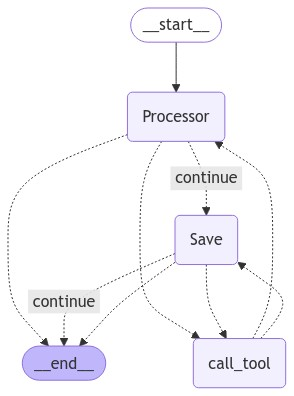

In [67]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

In [68]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Execute the workflow of calling the tools to scrape the website and then save the data to my local storage. The tool call will help save the data for you."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Processor': {'messages': [AIMessage(content="I can help with scraping the website to retrieve data, but I don't have the ability to save data directly to your local storage. You might need to manually save the data after I retrieve it for you. Let's start by scraping the website.\n\nI'll proceed with the tool call to scrape the website.", additional_kwargs={'tool_calls': [{'id': 'call_trbqKNsz5W9O2j5RD79RbgNQ', 'function': {'arguments': '{}', 'name': 'process_website_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 188, 'total_tokens': 260, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b68a8204b', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Processor', id='run-25c20818-b305-42c5-947a-bfffa2353f53-0', tool_calls=[{'name': 'process_website_